In [31]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bioinformatics Libraries
import scanpy as sc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Scapy Settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.2 scipy==1.11.4 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [32]:
# Load the pbmc3k dataset
sc.datasets.pbmc3k()
adata = sc.read_10x_mtx(
    # the directory with the `.mtx` file
    './data/filtered_gene_bc_matrices/hg19/',
    # use gene symbols for the variable names (variables-axis index)
    var_names='gene_symbols',
    # write a cache file for faster subsequent reading
    cache=True,
)

adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
adata.write('write/pbmc3k_raw.h5ad', compression='gzip')
print(adata)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad
AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


normalizing counts per cell
    finished (0:00:00)


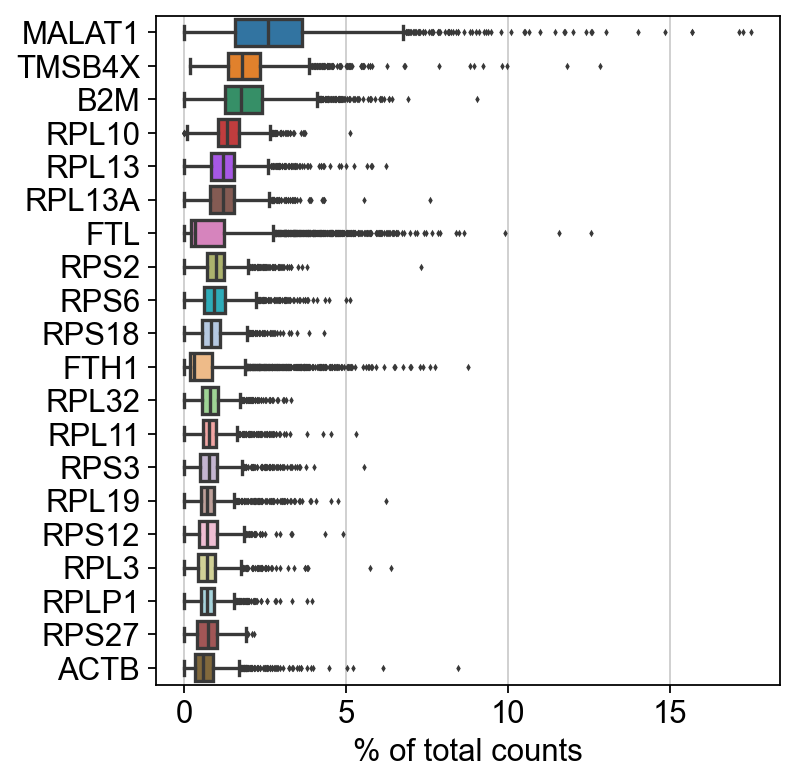

In [33]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )

In [34]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


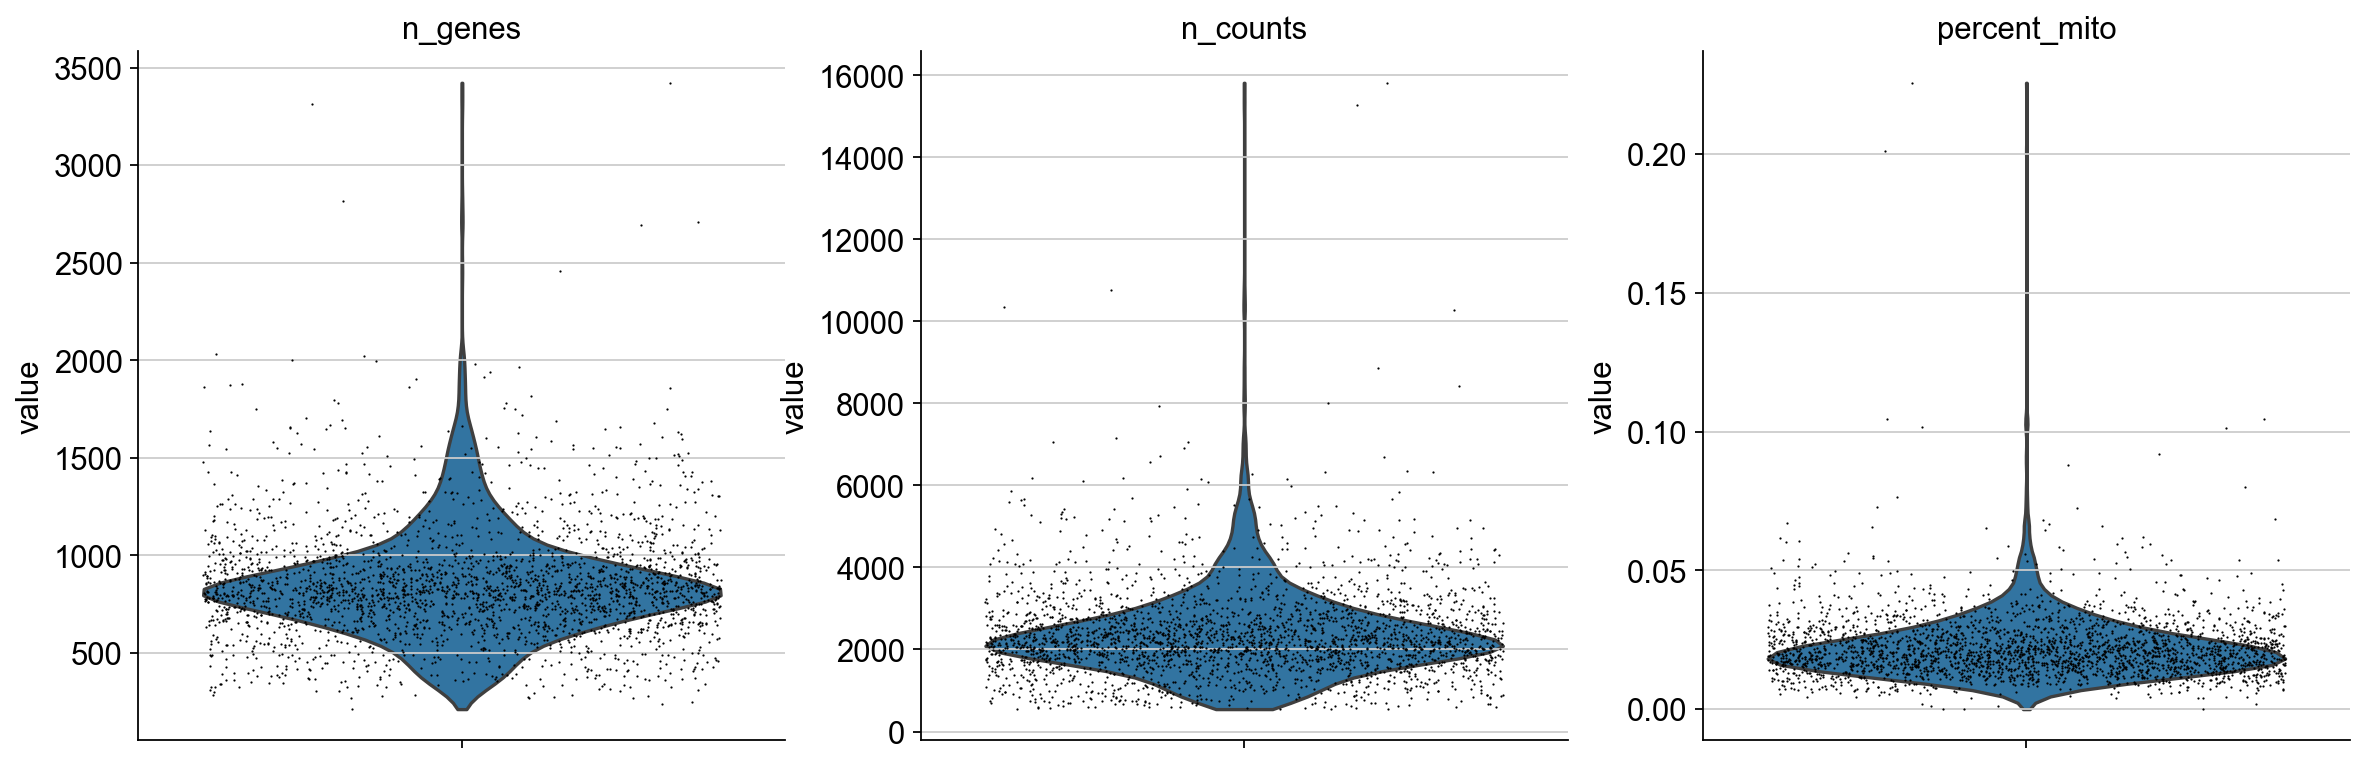

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'


In [35]:
# quality control
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                jitter=0.4, multi_panel=True)

adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)


In [36]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)


normalizing counts per cell


    finished (0:00:00)


In [37]:
# Store the raw data
adata.raw = adata

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


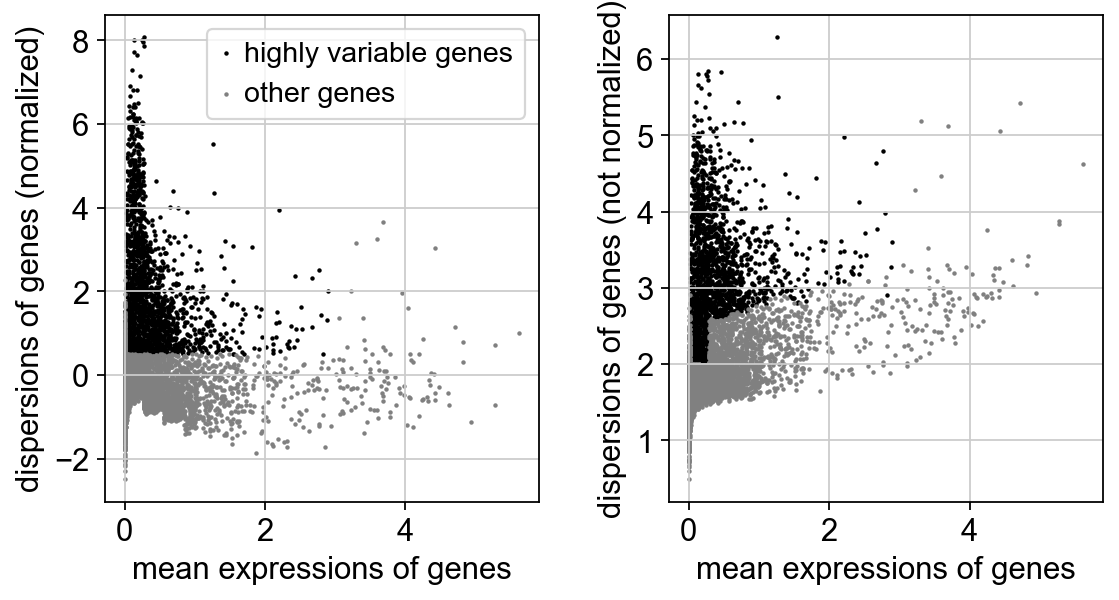

1838


In [38]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# Filter the data
adata = adata[:, adata.var.highly_variable]

# Summarize the highly variable genes
print(adata.var.highly_variable.sum())


In [39]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:02)


In [40]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10 to remove extreme outliers.
sc.pp.scale(adata, max_value=10)

In [41]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

## Dimension Reduction

### PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


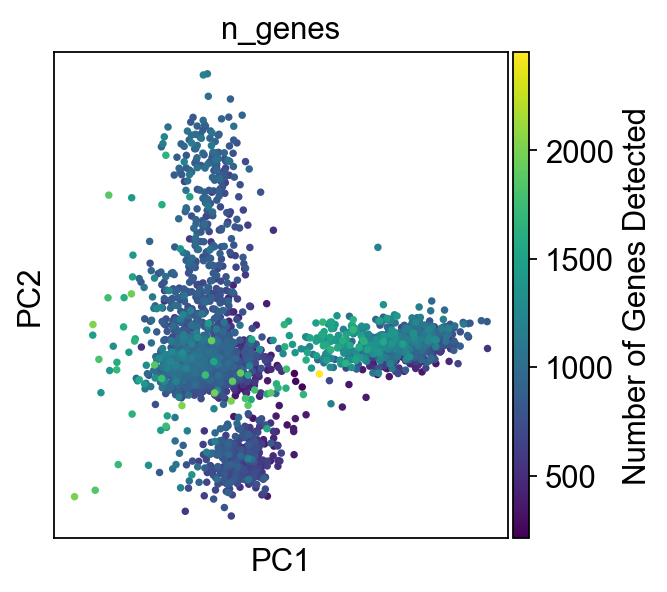

In [42]:
# Run PCA
sc.tl.pca(adata, svd_solver='arpack')

# Visualize the PCA results with coloring by 'n_genes'
sc.pl.pca(adata, color='n_genes', show=False)  # `show=False` to prevent immediate plot display

# Get current axis and figure
ax = plt.gca()
fig = plt.gcf()

# Find the color bar in the current figure
colorbar = ax.collections[0].colorbar

# Set the label for the color bar
colorbar.set_label('Number of Genes Detected')

# Display the plot
plt.show()



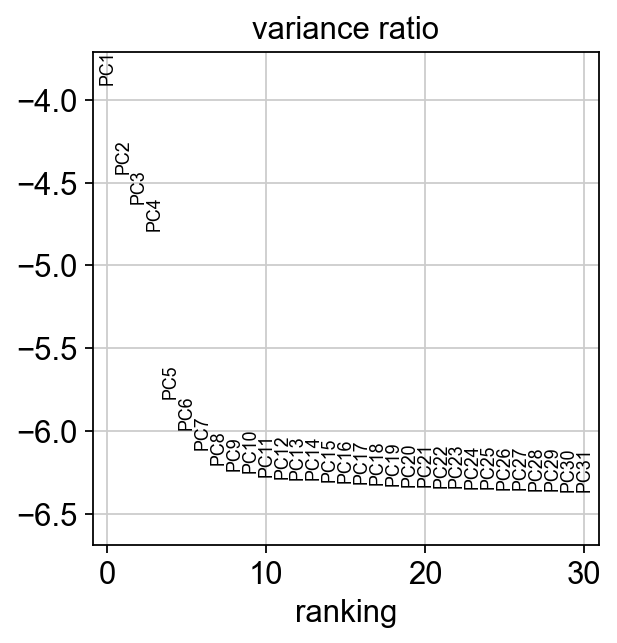

In [43]:
# Plot the explained variance (PCA)
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=30, show=True)  # `show=False` to prevent automatic display



In [44]:
# Write result file
adata.write('write/pbmc3k_pca.h5ad', compression='gzip')
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'